# Klasyfikator w dwie minuty

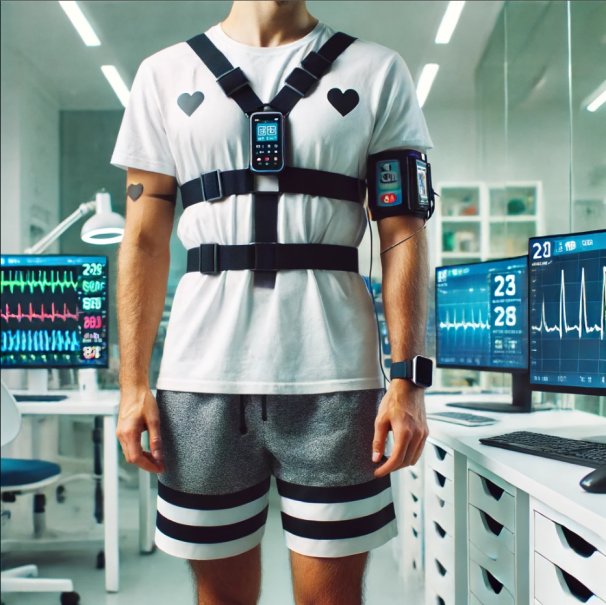

W trakcie tej olimpiady przyszło Ci się zmierzyć z różnym typem danych, m.in. z obrazami i tekstem. Ale czy zastanawiałaś/eś, na jakiej podstawie telefony lub opaski sportowe wiedzą o tym, jaką aktywność aktualnie wykonujecie?

W Twoim telefonie znajdują się rozmaite sensory, w tym akcelerometr, żyroskop, a nawet barometr. Na podstawie sygnałów pochodzących z tych urządzeń (mierzonych w pewnym okresie) telefon jest w stanie rozpoznać aktywność użytkownika.

Tego typu dane nazywamy **(wielowymiarowymi) szeregami czasowymi**, ponieważ w ustalonej chwili otrzymujemy dane w kilku wymiarach, np. z różnych osi akcelerometru.

W rzeczywistości etykietowanie danych jest kosztowne i wymaga wiedzy eksperta, dlatego zazwyczaj jedynie część danych posiada etykiety, zaś przyporządkowanie etykiet dla reszty danych wykonywane jest automatycznie.

Self-supervised learning to technika polegająca na nauce reprezentacji danych bez użycia ich etykiet. Wyuczone reprezentacje, nazywane ukrytymi (latents), są zazwyczaj osadzone w niżej wymiarowej przestrzeni oraz dobrze reprezentują dane wejściowe. Są one później wykorzystywane w tzw. downstream taskach, np. klasyfikacji, w której uczymy model na reprezentacjach ukrytych, a nie na oryginalnych danych.

## Pliki

- `train_x_big.pt` - pomiary pochodzące z czujników; mają one posłużyć za zbiór treningowy, ale nie dysponujemy etykietami dla tych danych;
- `train_x_small.pt`- mały podzbiór zbioru treningowego, do którego elementów posiadamy etykiety;
- `train_y_small.pt` - etykiety dla podzbioru pomiarów zawartych w `train_x_small.pt`;
- `val_x.pt` - pomiary pochodzące z czujników, które mają posłużyć za zbiór walidacyjny;
- `val_y.pt` - etykiety dla danych w zbiorze walidacyjnym zawartych w `val_x.pt`.

### Zadanie
Twoim zadaniem jest:
1. Wytrenowanie modelu w trybie self-supervised, uczącego się ogólnej reprezentacji danych treningowych (`train_x_big.pt`) bez informacji o klasach;
2. Zaimplementowanie metody `finetune_and_predict` trenującej klasyfikator, którego danymi wejściowymi są zanurzenia (embeddingi) szeregów czasowych z pliku `train_x_small.pt`, uzyskane za pomocą modelu self-supervised z punktu pierwszego. Metoda musi zwracać numer wybranej klasy dla zadanego szeregu, zaś nie ich reprezentację gorącojedynkową (ang. *one-hot encoding*).

W trakcie testowania rozwiązań `train_y_small.pt` będzie miał inne klasy niż ten załączony do zadania. Będzie ich jednak ta sama liczba. Można myśleć o tym w ten sposób, że mamy tutaj klasy {"pieszo", "samochód"}, natomiast przy ewaluacji model będzie finetunowany na zbiorze etykiet {"rower", "pływanie"}.

### Ocenianie
Jakość zaproponowanego rozwiązania będzie zweryfikowana w postaci wyliczenia accuracy na zbiorze testowym, który dostępny jest jedynie dla organizatorów. Zbiór testowy jest zbalansowany, a zawarte w nim szeregi czasowe cechują się charakterystykami porównywalnymi do zbioru walidacyjnego.

Za to zadanie możesz zdobyć pomiędzy 0 i 1 punktów. Zdobędziesz 0 punktów jeśli dokładność klasyfikacji na zbiorze testowym wyniesie poniżej 70%, a 1 punkt jeśli wyniesie powyżej 90%. Pomiędzy tymi wartościami, wynik rośnie liniowo z wartością kryterium.

### Pliki zgłoszeniowe
- Ten notebook
- Wagi modelu (`encoder.pt`)

### Ograniczenia

Ewaluacja twojego rozwiązania (bez treningu, flaga `FINAL_EVALUATION_MODE` ustawiona na `True`) powinna trwać nie dłużej niż 2 minuty na Google Colab z GPU T4.
Wykonanie skryptu na Google Colab z GPU z flagą `FINAL_EVALUATION_MODE` ustawioną na `False` powinno wytrenować model i wygenerować plik z wagami w czasie nie dłuższym niż 10 minut.
Rozmiar pliku `encoder.pt` nie powinien przekroczyć 10MB.

In [1]:
FINAL_EVALUATION_MODE = False

Poniżej zapewniono kod do zapisywania oraz ewaluacji modelu, a także ładowania danych. Możesz, ale nie musisz z niego korzystać.

Poniższe klasy oraz metody można dowolnie modyfikować, należy jedynie pamiętać aby metoda `finetune_and_predict()` przyjmowała cztery argumenty `(X_train_small, y_train_small, X_test, model_path)`

## Kod startowy

Na początek zaimportujmy wszystkie niezbędne biblioteki, zdefiniujmy instancje klas obsługujące dane (`DataLoader`), niezbędne hiperparametry oraz funkcję do zapisywania modeli.

In [1]:
import os
import random
import warnings

import gdown
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")

In [2]:
# NIE ZMIENIAJ TYCH WARTOŚCI
DEVICE = torch.device("cuda")
MODEL_FP = "./encoder.pt"

In [3]:
# TE WARTOŚCI MOŻNA ZMIENIAĆ
SEED =  42
EPOCHS = 200
N_CLASS = 6
N_CHANNEL = 3
N_LENGTH = 206
PROJECTION_DIM = 64
LOGISTIC_BATCH_SIZE = 64
LOGISTIC_EPOCHS = 10
FINETUNE_SEED = 42

In [ ]:
if not FINAL_EVALUATION_MODE:
    ! gdown https://drive.google.com/uc?id=1RxxsAQ6memLe4B0fePJD4cV_SIuRmhmw
    # ! gdown https://drive.google.com/uc?id=1K7873pSrnIEvQe4HxhvD0S6Ur-7bEmfm
    # ! gdown https://drive.google.com/uc?id=16ynUNF1WicH37L5iJszsfvVc-NJPzz8y
    ! unzip self_supervised.zip
    

In [13]:
class CustomTensorDataset(Dataset):
    """TensorDataset with support of transforms."""
    def __init__(self, data, transform_A=None, transform_B=None):
        assert all(data[0].shape[0] == item.shape[0] for item in data)
        self.data = data
        self.transform_A = transform_A
        self.transform_B = transform_B

    def __getitem__(self, index):
        x = self.data[0][index]

        if self.transform_A:
            x1 = self.transform_A(x)
        else:
            x1 = x
        if self.transform_B:
            x2 = self.transform_B(x)
        else:
            x2 = x
        y = self.data[1][index]

        return torch.tensor(x1).float(), torch.tensor(x2).float(), torch.tensor(y)

    def __len__(self):
        return self.data[0].shape[0]

In [14]:
def setup_seed(seed=42):
    """Setup seed for the reproducipility"""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

## Szkielet rozwiązania

### Modele: encoder i klasyfikator

Poniżej zaimplementowano przykładowe (i niezbyt skuteczne) rozwiązanie zadania. Zaprezentowany został prosty enkoder, którego celem jest stworzenie użytecznej reprezentacji danych wykorzystywanej później przez prosty klasyfikator typu perceptron wielowarstwowy.

In [15]:
# Popraw poniższą klasę!

class SimpleEncoder(nn.Module):
    def __init__(self, projection_dim, n_channel, n_length=240):
        super(SimpleEncoder, self).__init__()
        self.n_features = n_channel * n_length
        self.projector = nn.Sequential(
            nn.Linear(self.n_features, self.n_features // 2),
            nn.ReLU(),
            nn.Linear(self.n_features // 2, projection_dim),
        )

    def forward(self, x_i):
        h_i = x_i.flatten(start_dim=1, end_dim=-1)
        z_i = self.projector(h_i)
        return h_i, z_i

    def save_model(self, model):
        torch.save(model.state_dict(), MODEL_FP)

In [16]:
# Popraw poniższą klasę!

class MLPClassifier(nn.Module):
    def __init__(self, n_features, n_classes):
        super(MLPClassifier, self).__init__()
        n_dim = n_features // n_classes // 2 * n_classes

        self.model = nn.Sequential(
            nn.Linear(n_features, n_dim),
            nn.ReLU(),
            nn.Linear(n_dim, n_classes)
        )

    def forward(self, x):
        return self.model(x)

### Trening encodera
Jeżeli chcemy wytrenować enkoder, możemy skorzystać z poniższej funkcji. W naszym niezbyt skutecznym rozwiązaniu zostawiamy go z losowymi wagami.

In [17]:
# Popraw poniższą funkcję!

def train(unlabelled_train_loader, encoder_model):
    """Wytenuj model (encoder) na podstawie danych niepoetykietowanych."""
    optimizer = None  # TODO
    criterion = None  # TODO
    loss_epoch = []
    for epoch in range(LOGISTIC_EPOCHS):
        for step, (x_i, x_j, _) in enumerate(unlabelled_train_loader):
            optimizer.zero_grad()
            x_i = x_i.to(DEVICE)
            
            # TODO

            loss = criterion(...)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
    mean_loss = sum(loss_epoch) / len(loss_epoch)
    return mean_loss
    
if not FINAL_EVALUATION_MODE:
    X_train_big = torch.load("train_x_big.pt")
    encoder_model = SimpleEncoder(
        projection_dim=PROJECTION_DIM,
        n_channel=N_CHANNEL,
        n_length=N_LENGTH
    )

    encoder_model = encoder_model.to(DEVICE)
    encoder_model.save_model(encoder_model)
    # TODO: train(train_loader, model)

### Trening klasyfikatora

In [18]:
# Popraw poniższą funkcję!

def finetune(labelled_data_loader, encoder, classifier):
    """Dotrenuj modele (encoder, classifier) na danych poetykietowanych."""
    optimizer = torch.optim.Adam(classifier.parameters(), lr=3e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(LOGISTIC_EPOCHS):
        loss_epoch = []
        encoder.train()
        classifier.train()
        for n_batch, (x, x_aug, y) in enumerate(labelled_data_loader):
            optimizer.zero_grad()
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            with torch.no_grad():
                h, z = encoder(x)
            output = classifier(h).to(DEVICE)
            y = y.squeeze(-1).type(torch.LongTensor).to(DEVICE)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            loss_epoch.append(loss.item())
        mean_loss = sum(loss_epoch) / len(loss_epoch)

    return mean_loss

### Funkcja dotrenowująca i przewidująca 
Na podstawie poniższej funkcji będzie obliczony Twój wynik. Pamiętaj, aby sprawdzić poprawność formalną Twojego rozwiązania skryptem walidacyjnym!

In [19]:
# Popraw poniższą funkcję!

def finetune_and_predict(X_train_small, y_train_small, X_test, model_path):
    """W czasie testów uruchomimy tą funkcję z danymi testowymi. 
    Nie zmieniaj sygnatury tej funkcji, tzn. liczby, nazw argumentów i ich kolejności.
    
    Argumenty:
    X_train_small -- tensor danych treningowych o wymiarach (N, 1, 3, 206), gdzie N to liczba niezależnych pomiarów w zbiorze,
    y_train_small -- wektor etykiet dla zbioru treningowego o długości N,
    X_test -- tensor danych testowych o wymiarach (M, 1, 3, 206), gdzie M to liczba niezależnych pomiarów w zbiorze,

    Return:
    Funkcja powinna zwrócić wektor o długości M przewidywanych etykiet dla zbioru X_test.
    """
    setup_seed(FINETUNE_SEED)

    train_dataset = CustomTensorDataset((X_train_small, y_train_small))

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=LOGISTIC_BATCH_SIZE,
        shuffle=True,
        drop_last=True,
    )

    encoder_model = SimpleEncoder(
        projection_dim=PROJECTION_DIM,
        n_channel=N_CHANNEL,
        n_length=N_LENGTH
    )

    encoder_model.load_state_dict(torch.load(model_path, map_location=DEVICE.type))
    encoder_model = encoder_model.to(DEVICE)
    n_classes = N_CLASS
    classifier = MLPClassifier(encoder_model.n_features, n_classes)
    classifier = classifier.to(DEVICE)
    mean_loss_train = finetune(train_loader, encoder_model, classifier)
    x = torch.tensor(X_test).to(DEVICE)
    h, z = encoder_model(x)
    output = classifier(h).to(DEVICE)
    predicted = output.argmax(1)
    assert len(predicted.shape) == 1
    assert len(predicted) == len(X_test)
    assert predicted.dtype == torch.int64
    return predicted

## Ewaluacja

Twój kod zostanie zewaluowany w sposób podobny do poniższego. Pamiętaj, że w testowym skrypcie, zastąpione zostaną wszystkie poniższe datasety: zarówno `X_train_small`, `y_train_small`, jak i `X_val`.

In [ ]:
X_val = torch.load("val_x.pt")
y_val = torch.load("val_y.pt")
if not FINAL_EVALUATION_MODE:
    X_train_small = torch.load("train_x_small.pt")
    y_train_small = torch.load("train_y_small.pt")
    pred = finetune_and_predict(X_train_small, y_train_small, X_val, MODEL_FP)
    print("Accuracy:", accuracy_score(y_val, pred.cpu().numpy()))